## Imports 

In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import gzip 
import json 
import polars as pl
import re
import ast

## Load Data 

In [18]:
# AUS user reviews might not be needed 
aus_user_reviews_path = "./data/australian_user_reviews.json.gz"

# AUS user items could be used for user demographic info 
# Or for user-to-user similarity if thats needed in the future
aus_user_items_path = "./data/australian_users_items.json.gz" 

# Game specific metadata, will be useful for predictions 
steam_games_path = "./data/steam_games.json.gz" 

# This in combination with the metadata will need to be used for predictions
# This file doesn't have user id or game metadata 
steam_reviews_path = "./data/steam_reviews.json.gz" # This should be the 1.2 GiB version 
steam_reviews_parquet = "./data/reviews.parquet"

products_parquet = "./data/products_X.parquet"

In [4]:
# If files dont exist: print 
for path in [steam_games_path, steam_reviews_path]:
    if not os.path.exists(path):
        print(f"File {path} does not exist")
        print("Please put the files in the ./data/ folder")

In [5]:
def read_file_lazily(file_path): 
    # Create a generator for the file to prevent OOM errors 
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i % 1000000 == 0:
                print(i)
            item = ast.literal_eval(line)
            yield item

def get_lazyframe_from_file_path(file_path):
    # Return lazy frame to prevent OOC and OOM errors
    return pl.LazyFrame(read_file_lazily(file_path))

### Steam Games Metadata

In [6]:
games_df = get_lazyframe_from_file_path(steam_games_path)

0


In [10]:
games_df.head().collect()

publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
str,list[str],str,str,str,str,list[str],f64,str,list[str],str,bool,str,str,str,str
"""Kotoshiro""","[""Action"", ""Casual"", … ""Strategy""]","""Lost Summoner Kitty""","""Lost Summoner Kitty""","""http://store.steampowered.com/…","""2018-01-04""","[""Strategy"", ""Action"", … ""Simulation""]",4.49,"""http://steamcommunity.com/app/…","[""Single-player""]","""4.99""",false,"""761140""","""Kotoshiro""",null,null
"""Making Fun, Inc.""","[""Free to Play"", ""Indie"", … ""Strategy""]","""Ironbound""","""Ironbound""","""http://store.steampowered.com/…","""2018-01-04""","[""Free to Play"", ""Strategy"", … ""Design & Illustration""]",null,"""http://steamcommunity.com/app/…","[""Single-player"", ""Multi-player"", … ""In-App Purchases""]","""Free To Play""",false,"""643980""","""Secret Level SRL""","""Mostly Positive""",null
"""Poolians.com""","[""Casual"", ""Free to Play"", … ""Sports""]","""Real Pool 3D - Poolians""","""Real Pool 3D - Poolians""","""http://store.steampowered.com/…","""2017-07-24""","[""Free to Play"", ""Simulation"", … ""Multiplayer""]",null,"""http://steamcommunity.com/app/…","[""Single-player"", ""Multi-player"", … ""Stats""]","""Free to Play""",false,"""670290""","""Poolians.com""","""Mostly Positive""",null
"""彼岸领域""","[""Action"", ""Adventure"", ""Casual""]","""弹炸人2222""","""弹炸人2222""","""http://store.steampowered.com/…","""2017-12-07""","[""Action"", ""Adventure"", ""Casual""]",0.83,"""http://steamcommunity.com/app/…","[""Single-player""]","""0.99""",false,"""767400""","""彼岸领域""",null,null
null,null,"""Log Challenge""",null,"""http://store.steampowered.com/…",null,"[""Action"", ""Indie"", … ""Sports""]",1.79,"""http://steamcommunity.com/app/…","[""Single-player"", ""Full controller support"", … ""Room-Scale""]","""2.99""",false,"""773570""",null,null,null


In [11]:
# convert column 'id' to int 
cleaned_games_df = games_df.with_columns(pl.col("id").cast(pl.Int32))
cleaned_games_df.head().collect()

publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
str,list[str],str,str,str,str,list[str],f64,str,list[str],str,bool,i32,str,str,str
"""Kotoshiro""","[""Action"", ""Casual"", … ""Strategy""]","""Lost Summoner Kitty""","""Lost Summoner Kitty""","""http://store.steampowered.com/…","""2018-01-04""","[""Strategy"", ""Action"", … ""Simulation""]",4.49,"""http://steamcommunity.com/app/…","[""Single-player""]","""4.99""",false,761140,"""Kotoshiro""",null,null
"""Making Fun, Inc.""","[""Free to Play"", ""Indie"", … ""Strategy""]","""Ironbound""","""Ironbound""","""http://store.steampowered.com/…","""2018-01-04""","[""Free to Play"", ""Strategy"", … ""Design & Illustration""]",null,"""http://steamcommunity.com/app/…","[""Single-player"", ""Multi-player"", … ""In-App Purchases""]","""Free To Play""",false,643980,"""Secret Level SRL""","""Mostly Positive""",null
"""Poolians.com""","[""Casual"", ""Free to Play"", … ""Sports""]","""Real Pool 3D - Poolians""","""Real Pool 3D - Poolians""","""http://store.steampowered.com/…","""2017-07-24""","[""Free to Play"", ""Simulation"", … ""Multiplayer""]",null,"""http://steamcommunity.com/app/…","[""Single-player"", ""Multi-player"", … ""Stats""]","""Free to Play""",false,670290,"""Poolians.com""","""Mostly Positive""",null
"""彼岸领域""","[""Action"", ""Adventure"", ""Casual""]","""弹炸人2222""","""弹炸人2222""","""http://store.steampowered.com/…","""2017-12-07""","[""Action"", ""Adventure"", ""Casual""]",0.83,"""http://steamcommunity.com/app/…","[""Single-player""]","""0.99""",false,767400,"""彼岸领域""",null,null
null,null,"""Log Challenge""",null,"""http://store.steampowered.com/…",null,"[""Action"", ""Indie"", … ""Sports""]",1.79,"""http://steamcommunity.com/app/…","[""Single-player"", ""Full controller support"", … ""Room-Scale""]","""2.99""",false,773570,null,null,null


In [12]:
# Find null cols
print(cleaned_games_df.null_count().collect()[:, :8])
print(cleaned_games_df.null_count().collect()[:, 8:])

shape: (1, 8)
┌───────────┬────────┬──────────┬───────┬─────┬──────────────┬──────┬────────────────┐
│ publisher ┆ genres ┆ app_name ┆ title ┆ url ┆ release_date ┆ tags ┆ discount_price │
│ ---       ┆ ---    ┆ ---      ┆ ---   ┆ --- ┆ ---          ┆ ---  ┆ ---            │
│ u32       ┆ u32    ┆ u32      ┆ u32   ┆ u32 ┆ u32          ┆ u32  ┆ u32            │
╞═══════════╪════════╪══════════╪═══════╪═════╪══════════════╪══════╪════════════════╡
│ 8052      ┆ 3283   ┆ 2        ┆ 2050  ┆ 0   ┆ 2067         ┆ 163  ┆ 31910          │
└───────────┴────────┴──────────┴───────┴─────┴──────────────┴──────┴────────────────┘
shape: (1, 8)
┌─────────────┬───────┬───────┬──────────────┬─────┬───────────┬───────────┬───────────┐
│ reviews_url ┆ specs ┆ price ┆ early_access ┆ id  ┆ developer ┆ sentiment ┆ metascore │
│ ---         ┆ ---   ┆ ---   ┆ ---          ┆ --- ┆ ---       ┆ ---       ┆ ---       │
│ u32         ┆ u32   ┆ u32   ┆ u32          ┆ u32 ┆ u32       ┆ u32       ┆ u32       │
╞══════

### Steam Reviews

In [16]:
reviews_df = get_lazyframe_from_file_path(steam_reviews_path)

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000


In [46]:
reviews_df.head().collect()

username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
str,f64,i64,str,i64,str,str,bool,i64,i64,str,str
"""Chaos Syren""",0.1,41,"""725280""",0,"""2017-12-17""","""This would not be acceptable a…",false,1,null,null,null
"""₮ʜᴇ Wᴀʀᴛᴏɴ""",51.1,769,"""328100""",0,"""2017-12-27""","""looks like a facebook game""",false,1,null,null,null
"""hello?<""",14.6,2,"""328100""",1,"""2017-10-16""","""Better than Minecraft""",false,1,2,"""Product received for free""",null
"""Cyderine916""",5.0,64,"""35140""",0,"""2018-01-04""","""I love and idolized Batman and…",false,1,null,null,null
"""DarklyThinking""",16.6,577,"""35140""",1,"""2018-01-04""","""Still worth playing in 2018. P…",false,1,null,null,"""76561198007483075"""


In [35]:
# product id and user id to int 
cleaned_reviews_df = reviews_df.with_columns(pl.col("product_id").cast(pl.Int32), pl.col("user_id").cast(pl.Int64))

In [36]:
print(cleaned_reviews_df.null_count().collect()[:, :6])
print(cleaned_reviews_df.null_count().collect()[:, 6:])
hours_zero_count = cleaned_reviews_df.filter(pl.col("hours") == 0).count()
print(hours_zero_count.collect())

shape: (1, 6)
┌──────────┬───────┬──────────┬────────────┬────────────┬──────┐
│ username ┆ hours ┆ products ┆ product_id ┆ page_order ┆ date │
│ ---      ┆ ---   ┆ ---      ┆ ---        ┆ ---        ┆ ---  │
│ u32      ┆ u32   ┆ u32      ┆ u32        ┆ u32        ┆ u32  │
╞══════════╪═══════╪══════════╪════════════╪════════════╪══════╡
│ 0        ┆ 26537 ┆ 14961    ┆ 0          ┆ 0          ┆ 0    │
└──────────┴───────┴──────────┴────────────┴────────────┴──────┘
shape: (1, 6)
┌──────┬──────────────┬──────┬─────────────┬──────────────┬─────────┐
│ text ┆ early_access ┆ page ┆ found_funny ┆ compensation ┆ user_id │
│ ---  ┆ ---          ┆ ---  ┆ ---         ┆ ---          ┆ ---     │
│ u32  ┆ u32          ┆ u32  ┆ u32         ┆ u32          ┆ u32     │
╞══════╪══════════════╪══════╪═════════════╪══════════════╪═════════╡
│ 0    ┆ 0            ┆ 0    ┆ 6592313     ┆ 7647446      ┆ 4616846 │
└──────┴──────────────┴──────┴─────────────┴──────────────┴─────────┘
shape: (1, 12)
┌──────────┬

## Join Reviews and Games Metadata on Item ID

In [37]:
review_meta_df = cleaned_reviews_df.join(cleaned_games_df, left_on="product_id", right_on="id", how="inner")

In [38]:
print(review_meta_df.head().collect())

shape: (5, 27)
┌────────────┬───────┬──────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ username   ┆ hours ┆ products ┆ product_id ┆ … ┆ early_acce ┆ developer  ┆ sentiment ┆ metascore │
│ ---        ┆ ---   ┆ ---      ┆ ---        ┆   ┆ ss_right   ┆ ---        ┆ ---       ┆ ---       │
│ str        ┆ f64   ┆ i64      ┆ i32        ┆   ┆ ---        ┆ str        ┆ str       ┆ str       │
│            ┆       ┆          ┆            ┆   ┆ bool       ┆            ┆           ┆           │
╞════════════╪═══════╪══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ Chaos      ┆ 0.1   ┆ 41       ┆ 725280     ┆ … ┆ false      ┆ Vyacheslav ┆ Positive  ┆ null      │
│ Syren      ┆       ┆          ┆            ┆   ┆            ┆ Shilikhin  ┆           ┆           │
│ ₮ʜᴇ Wᴀʀᴛᴏɴ ┆ 51.1  ┆ 769      ┆ 328100     ┆ … ┆ false      ┆ Ino-Co     ┆ Mixed     ┆ null      │
│            ┆       ┆          ┆            ┆   ┆            ┆ Plus       ┆

In [41]:
print(review_meta_df.null_count().collect(streaming=True)[:, :6])
print(review_meta_df.null_count().collect(streaming=True)[:, 6:12])
print(review_meta_df.null_count().collect(streaming=True)[:, 12:18])
print(review_meta_df.null_count().collect(streaming=True)[:, 18:24])
print(review_meta_df.null_count().collect(streaming=True)[:, 24:])

shape: (1, 6)
┌──────────┬───────┬──────────┬────────────┬────────────┬──────┐
│ username ┆ hours ┆ products ┆ product_id ┆ page_order ┆ date │
│ ---      ┆ ---   ┆ ---      ┆ ---        ┆ ---        ┆ ---  │
│ u32      ┆ u32   ┆ u32      ┆ u32        ┆ u32        ┆ u32  │
╞══════════╪═══════╪══════════╪════════════╪════════════╪══════╡
│ 0        ┆ 26537 ┆ 14962    ┆ 0          ┆ 0          ┆ 0    │
└──────────┴───────┴──────────┴────────────┴────────────┴──────┘
shape: (1, 6)
┌──────┬──────────────┬──────┬─────────────┬──────────────┬─────────┐
│ text ┆ early_access ┆ page ┆ found_funny ┆ compensation ┆ user_id │
│ ---  ┆ ---          ┆ ---  ┆ ---         ┆ ---          ┆ ---     │
│ u32  ┆ u32          ┆ u32  ┆ u32         ┆ u32          ┆ u32     │
╞══════╪══════════════╪══════╪═════════════╪══════════════╪═════════╡
│ 0    ┆ 0            ┆ 0    ┆ 6597878     ┆ 7653829      ┆ 4620442 │
└──────┴──────────────┴──────┴─────────────┴──────────────┴─────────┘
shape: (1, 6)
┌───────────┬

### Clean Reviews

In [49]:
# drop early access right column, drop samples with null user_id, rename data to review_date 
# drop samples with null sentiment 
cleaned_review_meta_df = (
    review_meta_df
    .drop(["early_access_right", "username", "app_name"])
    .with_columns(pl.col("date").alias("review_date"))
    .filter(pl.col("user_id").is_not_null())
)

In [50]:
# Number of reviews where user id is not null
print(cleaned_review_meta_df.collect().height)

3179096


### Save Cleaned Data

In [52]:
cleaned_review_meta_df.collect().write_parquet("./data/cleaned_review_meta.parquet", compression="zstd", compression_level=9)

KeyboardInterrupt: 

#### Clean Again

In [3]:
df = pl.read_parquet("./data/cleaned_review_meta.parquet")

In [95]:
df.null_count()

hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,publisher,genres,title,url,release_date,tags,discount_price,reviews_url,specs,price,developer,sentiment,metascore,review_date
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
7904,9735,0,0,0,0,0,0,2737588,3128303,0,31274,12898,0,0,3319,18,3173566,0,13864,26609,19518,482,1276230,0


In [104]:
# Convert to datetime
df_datetime = df.with_columns(
    pl.col("review_date").str.to_date(strict=False),
    pl.col("release_date").str.to_date(strict=False)
)

In [105]:
df_datetime.null_count()

hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,publisher,genres,title,url,release_date,tags,discount_price,reviews_url,specs,price,developer,sentiment,metascore,review_date
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
7904,9735,0,0,0,0,0,0,2737588,3128303,0,31274,12898,0,0,15543,18,3173566,0,13864,26609,19518,482,1276230,0


In [106]:
# Remove nulls 
df_filtered = df_datetime.filter(
    pl.col("sentiment").is_not_null() &
    pl.col("tags").is_not_null() &
    pl.col("release_date").is_not_null() &
    pl.col("genres").is_not_null() & 
    pl.col("specs").is_not_null() & 
    pl.col("price").is_not_null() & 
    pl.col("hours").is_not_null() &
    pl.col("publisher").is_not_null() &
    pl.col("developer").is_not_null() & 
    pl.col("products").is_not_null() & 
    pl.col("review_date").is_not_null() &
    pl.col("release_date").is_not_null()
)
    
df_filtered.null_count()

hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,publisher,genres,title,url,release_date,tags,discount_price,reviews_url,specs,price,developer,sentiment,metascore,review_date
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,2653981,3031734,0,0,0,0,0,0,0,3076114,0,0,0,0,0,1222572,0


In [107]:
df_filtered[0]

hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,publisher,genres,title,url,release_date,tags,discount_price,reviews_url,specs,price,developer,sentiment,metascore,review_date
f64,i64,i32,i64,str,str,bool,i64,i64,str,i64,str,list[str],str,str,date,list[str],f64,str,list[str],str,str,str,str,date
16.6,577,35140,1,"""2018-01-04""","""Still worth playing in 2018. P…",false,1,null,null,76561198007483075,"""Warner Bros. Interactive Enter…","[""Action"", ""Adventure""]","""Batman: Arkham Asylum Game of …","""http://store.steampowered.com/…",2010-03-26,"[""Action"", ""Batman"", … ""Horror""]",null,"""http://steamcommunity.com/app/…","[""Single-player"", ""Steam Achievements"", … ""Steam Cloud""]","""19.99""","""Rocksteady Studios,Feral Inter…","""Overwhelmingly Positive""","""91""",2018-01-04


In [109]:
# Drop items and reviews with dates before June 2012, 1 month before first player count reading
from datetime import datetime
cutoff_date = datetime(2012, 6, 1) 
df_filtered_date = df_filtered.filter(pl.col("review_date") >= cutoff_date) 
df_filtered_date = df_filtered_date.filter(pl.col("release_date") >= cutoff_date)
print(len(df_filtered_date))

2425381


In [110]:
# polars: print unique product_id 
review_columns = ["user_id", "product_id", "review_date", "hours", "text", "products", "page", "page_order", "found_funny", "reviews_url"]
product_columns = ["product_id", "sentiment", "developer", "publisher", "release_date", "tags", "genres", "specs", "price"]

reviews = df_filtered_date.select(review_columns)
products = df_filtered_date.unique("product_id").select(product_columns)
print(len(reviews)) 
print(len(products))


2425381
11475


In [111]:
reviews.write_parquet("./data/reviews.parquet", compression="zstd", compression_level=11)

In [112]:
products.write_parquet("./data/products_X.parquet", compression="zstd", compression_level=11)

#### Get Labels 

In [ ]:
products = pl.read_parquet("./data/products_X.parquet")

# Steam Review Data

In [16]:
review_df = pd.read_parquet(steam_reviews_parquet)

In [17]:
print(review_df)

                   user_id  product_id review_date   hours  \
0        76561197970402776      707610  2017-10-16     1.1   
1        76561198060686749      328100  2017-06-23     3.8   
2        76561198159791799      725280  2017-11-13     0.3   
3        76561198048988003      350280  2018-01-04     1.3   
4        76561198011965365      328100  2017-03-31     1.3   
...                    ...         ...         ...     ...   
2425376  76561197962161824      252490  2013-12-11  2775.2   
2425377  76561198010660367      252490  2013-12-11    82.2   
2425378  76561197983773018      252490  2013-12-11   261.7   
2425379  76561198089897928      252490  2013-12-11  1215.2   
2425380  76561198048207033      252490  2013-12-11    50.5   

                                                      text  products   page  \
0        no sound. icons don't work. re-installed but n...       729      1   
1        A nice game, but better not to get started.\nT...       431      1   
2        THE WORST

In [25]:
# number of reviews per user
user_review_count = review_df['user_id'].value_counts()

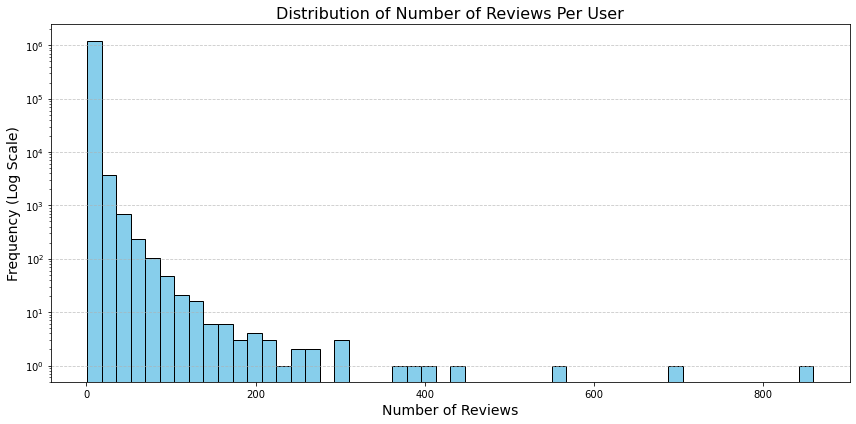

In [26]:
# Plot the distribution using a histogram
plt.figure(figsize=(12, 6))
plt.hist(user_review_count, bins=50, color='skyblue', edgecolor='black', log=True)  # Use log scale for clarity

# Add labels and title
plt.title('Distribution of Number of Reviews Per User', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=14)
plt.ylabel('Frequency (Log Scale)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [27]:
# number of reviews per game
game_review_count = review_df['product_id'].value_counts()

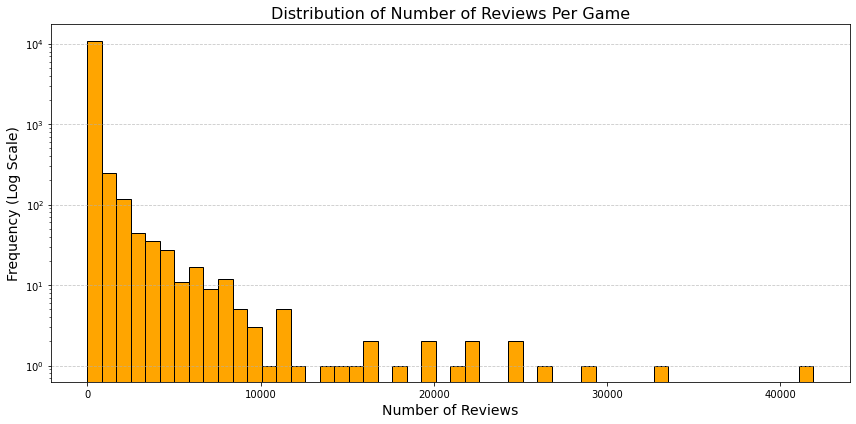

In [28]:
# Plot the distribution using a histogram
plt.figure(figsize=(12, 6))
plt.hist(game_review_count, bins=50, color='orange', edgecolor='black', log=True)  # Use log scale for clarity

# Add labels and title
plt.title('Distribution of Number of Reviews Per Game', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=14)
plt.ylabel('Frequency (Log Scale)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [19]:
products = pd.read_parquet(products_parquet)

In [20]:
print(products)

       product_id                sentiment            developer  \
0          708630           3 user reviews               HuBiao   
1          273580            Very Positive             Parallax   
2          529180                    Mixed      Snail Games USA   
3          378580          Mostly Positive         OCCA Studios   
4          424850                    Mixed           LInsoDeTeh   
...           ...                      ...                  ...   
11470      405950                 Positive            Rockodile   
11471      286260  Overwhelmingly Positive  ALICE IN DISSONANCE   
11472      485890                    Mixed       Ductape studio   
11473      517360          Mostly Positive        Sunward Games   
11474      238430          Mostly Positive      Monochrome, Inc   

             publisher release_date  \
0               HuBiao   2017-09-01   
1       Interplay Inc.   2014-02-19   
2      Snail Games USA   2017-07-20   
3       Strategy First   2015-08-27   


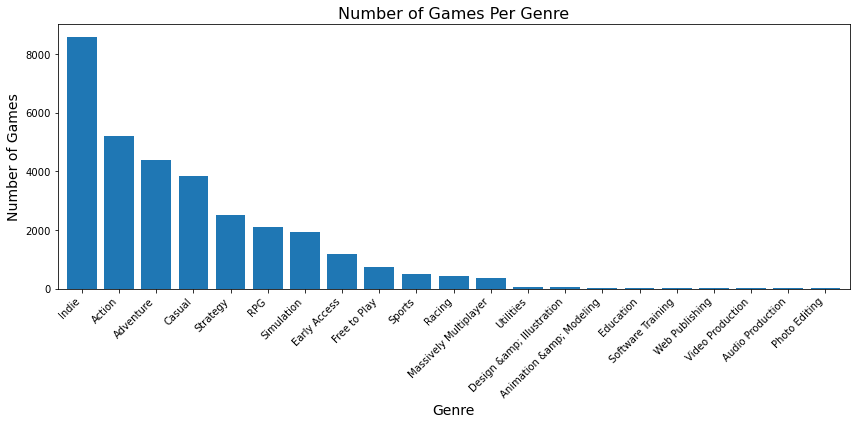

In [21]:
genres_exploded = products.explode('genres')

# number of games per genre
genre_count = genres_exploded['genres'].value_counts()

plt.figure(figsize=(12, 6))
genre_count.plot(kind='bar', width=0.8)

# Adding labels and title
plt.title('Number of Games Per Genre', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of Games', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

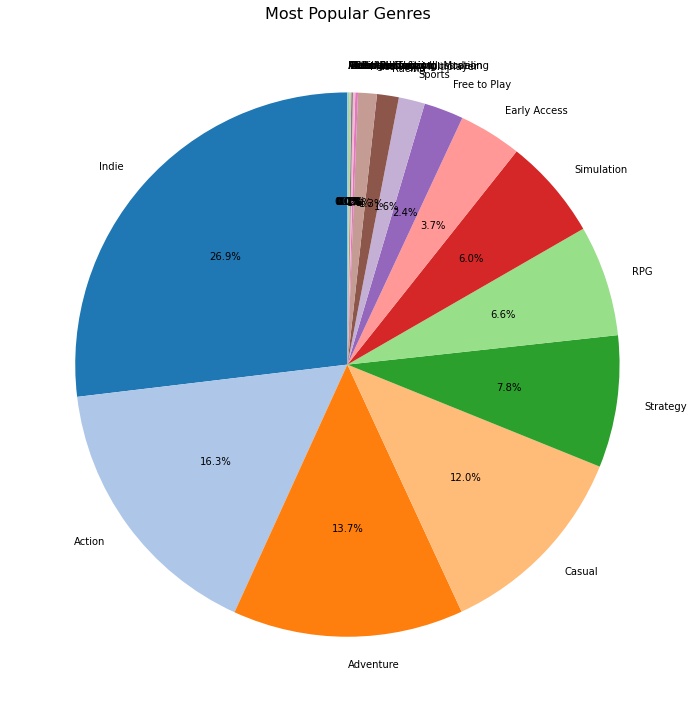

In [23]:
# as a pie chart
plt.figure(figsize=(10, 10))
genre_count.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='tab20')

# Adding title and adjusting layout
plt.title('Most Popular Genres', fontsize=16)
plt.ylabel('')  # Hides the y-axis label for better appearance
plt.tight_layout()
plt.show()

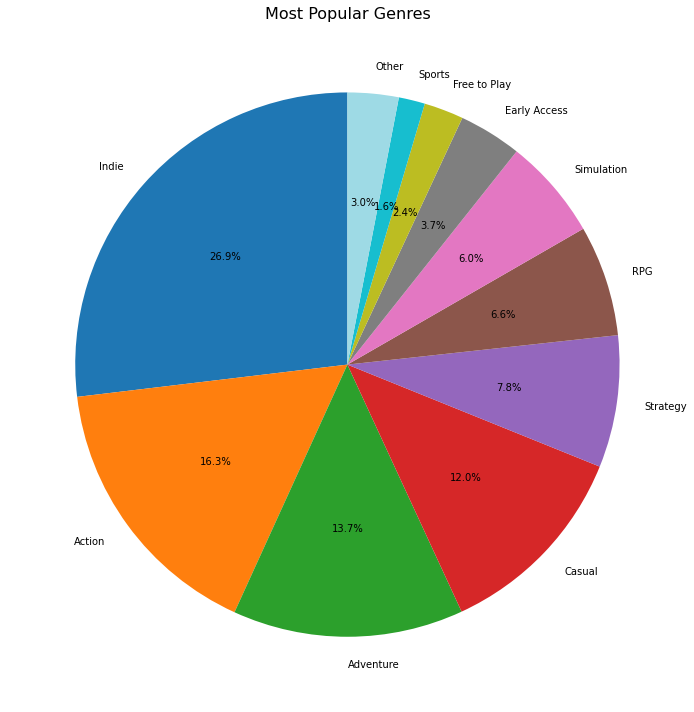

In [24]:
# only chart top 10
top_genres = genre_count.head(10)
other_count = genre_count[10:].sum()
top_genres['Other'] = other_count

plt.figure(figsize=(10, 10))
top_genres.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    cmap='tab20',
    labels=top_genres.index,
)

# Add title and adjust layout
plt.title('Most Popular Genres', fontsize=16)
plt.ylabel('')  # Hide the y-axis label for a cleaner appearance
plt.tight_layout()
plt.show()